# Gym Exercise Recommendation

The idea of this project is to create a recommendation based algorithm built on top of a gym exercise dataset.
The goal for v1 release is to have a model that will recommend exercises based on user level (beginner, intermediate, advanced), type of exercise/training, equipment available and body part.
For the v2 release, I'd like to have some user information/profiles in a way that a content-based and collaborative filtering.
For the v3 release, I'm aiming to have a frontend webapp/mobile app users can interact with.
For the v4 release, the goal is to also include meal planning. Users will be suggested meals based on their weight, age, body-type and gym goal (getting more swollen, losing weight, etc).

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [28]:
data = pd.read_csv(r'/Users/steelo/Library/CloudStorage/OneDrive-Personal/Dev/codeProjects/gym_recommendation/megaGymDataset.csv')

In [29]:
data.rename( columns={'Unnamed: 0':'ID'}, inplace=True )
data

,ID,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate,0.0,NaN
1,1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
2,2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
3,3,Banded crunch,The banded crunch is an exercise targeting the...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
4,4,Crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2913,2913,EZ-bar skullcrusher-,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,8.1,Average
2914,2914,Lying Close-Grip Barbell Triceps Press To Chin,NaN,Strength,Triceps,E-Z Curl Bar,Beginner,8.1,Average
2915,2915,EZ-Bar Skullcrusher - Gethin Variation,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,NaN,NaN
2916,2916,TBS Skullcrusher,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,NaN,NaN


In [30]:
sqldf("SELECT * FROM data GROUP BY Type", globals())

,ID,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc
0,149,Roc Everest,None,Cardio,Abdominals,Other,Intermediate,NaN,None
1,1217,Kneeling Jump Squat,None,Olympic Weightlifting,Glutes,Barbell,Beginner,7.6,Average
2,96,Sledgehammer swing,The sledgehammer swing is an exercise working ...,Plyometrics,Abdominals,Other,Intermediate,8.6,Average
3,917,Bench Press With Short Bands,None,Powerlifting,Chest,Bands,Beginner,0.0,None
4,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate,0.0,None
5,204,Stomach Vacuum,None,Stretching,Abdominals,Body Only,Beginner,8.5,Average
6,1159,Forward Drag with Press,None,Strongman,Chest,Other,Beginner,6.0,Average


In [31]:
le = LabelEncoder() # Create a LabelEncoder object

# Fit the LabelEncoder to the data and transform it
data['Type_encoded'] = le.fit_transform(data['Type'])
data['Equipment_encoded'] = le.fit_transform(data['Equipment'])
data['Level_encoded'] = le.fit_transform(data['Level'])
data['BodyPart_encoded'] = le.fit_transform(data['BodyPart'])
# 
# # Inverse transform the encoded data to get the original text values
# data['Type_original'] = le.inverse_transform(data['Type_encoded'])
# data['Equipment_original'] = le.inverse_transform(data['Equipment_encoded'])
# data['Level_original'] = le.inverse_transform(data['Level_encoded'])
# data['BodyPart_original'] = le.inverse_transform(data['BodyPart_encoded'])

data

,ID,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc,Type_encoded,Equipment_encoded,Level_encoded,BodyPart_encoded
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate,0.0,NaN,4,0,2,0
1,1,Banded crunch isometric hold,The banded crunch isometric hold is an exercis...,Strength,Abdominals,Bands,Intermediate,NaN,NaN,4,0,2,0
2,2,FYR Banded Plank Jack,The banded plank jack is a variation on the pl...,Strength,Abdominals,Bands,Intermediate,NaN,NaN,4,0,2,0
3,3,Banded crunch,The banded crunch is an exercise targeting the...,Strength,Abdominals,Bands,Intermediate,NaN,NaN,4,0,2,0
4,4,Crunch,The crunch is a popular core exercise targetin...,Strength,Abdominals,Bands,Intermediate,NaN,NaN,4,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,2913,EZ-bar skullcrusher-,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,8.1,Average,4,5,2,16
2914,2914,Lying Close-Grip Barbell Triceps Press To Chin,NaN,Strength,Triceps,E-Z Curl Bar,Beginner,8.1,Average,4,5,0,16
2915,2915,EZ-Bar Skullcrusher - Gethin Variation,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,NaN,NaN,4,5,2,16
2916,2916,TBS Skullcrusher,The EZ-bar skullcrusher is a popular exercise ...,Strength,Triceps,E-Z Curl Bar,Intermediate,NaN,NaN,4,5,2,16


<Axes: >

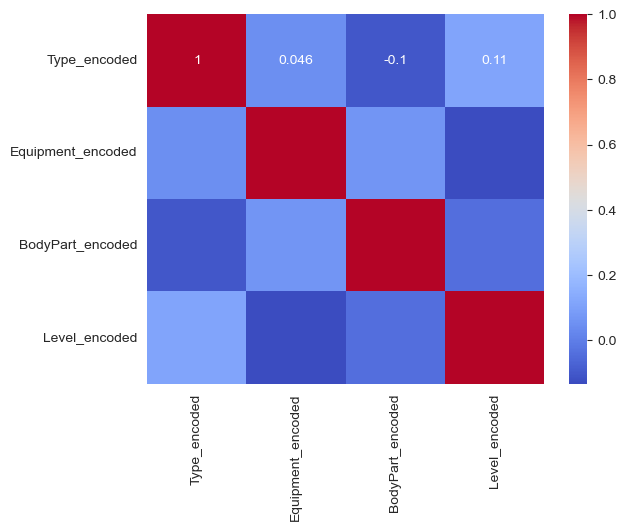

In [32]:
heatmap_columns = ['Type_encoded', 'Equipment_encoded', 'BodyPart_encoded', 'Level_encoded']
sns.heatmap(data[heatmap_columns].corr(), annot=True, cmap='coolwarm')


In [33]:
# Compute Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(data['Type_encoded'], data['Level_encoded'])
print("Pearson correlation coefficient for 'Type_encoded' and 'Level_encoded':", correlation_coefficient)
print("P-value:", p_value)

correlation_coefficient, p_value = pearsonr(data['Type_encoded'], data['BodyPart_encoded'])
print("Pearson correlation coefficient for 'Type_encoded' and 'BodyPart_encoded':", correlation_coefficient)
print("P-value:", p_value)

correlation_coefficient, p_value = pearsonr(data['Level_encoded'], data['BodyPart_encoded'])
print("Pearson correlation coefficient for 'Level_encoded' and 'BodyPart_encoded':", correlation_coefficient)
print("P-value:", p_value)

correlation_coefficient, p_value = pearsonr(data['Equipment_encoded'], data['BodyPart_encoded'])
print("Pearson correlation coefficient for 'Equipment_encoded' and 'BodyPart_encoded':", correlation_coefficient)
print("P-value:", p_value)

correlation_coefficient, p_value = pearsonr(data['Equipment_encoded'], data['Level_encoded'])
print("Pearson correlation coefficient for 'Equipment_encoded' and 'Level_encoded':", correlation_coefficient)
print("P-value:", p_value)

correlation_coefficient, p_value = pearsonr(data['Equipment_encoded'], data['Type_encoded'])
print("Pearson correlation coefficient for 'Equipment_encoded' and 'Type_encoded':", correlation_coefficient)
print("P-value:", p_value)

Pearson correlation coefficient for 'Type_encoded' and 'Level_encoded': 0.1125080108593004
P-value: 1.0993840127818986e-09
Pearson correlation coefficient for 'Type_encoded' and 'BodyPart_encoded': -0.10376530824440382
P-value: 1.9316138077595137e-08
Pearson correlation coefficient for 'Level_encoded' and 'BodyPart_encoded': -0.04445567819867902
P-value: 0.016324077489777628
Pearson correlation coefficient for 'Equipment_encoded' and 'BodyPart_encoded': 0.06489075217355073
P-value: 0.00045234309440299396
Pearson correlation coefficient for 'Equipment_encoded' and 'Level_encoded': -0.13358682515446813
P-value: 4.306369753538245e-13
Pearson correlation coefficient for 'Equipment_encoded' and 'Type_encoded': 0.04590014951411112
P-value: 0.013149204295332359


In [34]:
columns = ['Type_encoded', 'Equipment_encoded', 'BodyPart_encoded', 'Level_encoded'] # Create a new DF
data1 = data[columns]

similarity_matrix = cosine_similarity(data1) # Calculate the Cosine Similarity between each pair of exercises

similarity_df = pd.DataFrame(similarity_matrix, index=data1.index, columns=data1.index) # Convert the similarity matrix to a DataFrame for better readability

similarity_df.index = data['ID'] # Replace the indices with the exercise titles

similarity_df.columns = data['ID'] # Replace the column names with the exercise titles

similarity_df

ID,0,1,2,3,4,5,6,7,8,9,...,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917
ID,,,,,,,,,,,,,,,,,,,,,
0,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.975900,0.975900,...,0.267261,0.267261,0.094281,0.257770,0.257770,0.257770,0.207600,0.257770,0.257770,0.257770
1,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.975900,0.975900,...,0.267261,0.267261,0.094281,0.257770,0.257770,0.257770,0.207600,0.257770,0.257770,0.257770
2,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.975900,0.975900,...,0.267261,0.267261,0.094281,0.257770,0.257770,0.257770,0.207600,0.257770,0.257770,0.257770
3,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.975900,0.975900,...,0.267261,0.267261,0.094281,0.257770,0.257770,0.257770,0.207600,0.257770,0.257770,0.257770
4,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.975900,0.975900,...,0.267261,0.267261,0.094281,0.257770,0.257770,0.257770,0.207600,0.257770,0.257770,0.257770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,0.25777,0.25777,0.25777,0.25777,0.25777,0.25777,0.25777,0.25777,0.314447,0.314447,...,0.985153,0.985153,0.953883,1.000000,1.000000,1.000000,0.993333,1.000000,1.000000,1.000000
2914,0.20760,0.20760,0.20760,0.20760,0.20760,0.20760,0.20760,0.20760,0.265908,0.265908,...,0.977894,0.977894,0.960285,0.993333,0.993333,0.993333,1.000000,0.993333,0.993333,0.993333
2915,0.25777,0.25777,0.25777,0.25777,0.25777,0.25777,0.25777,0.25777,0.314447,0.314447,...,0.985153,0.985153,0.953883,1.000000,1.000000,1.000000,0.993333,1.000000,1.000000,1.000000


In [35]:
def recommend_exercises(ID, similarity_df, num_recommendations=5):
    exercise_similarities = similarity_df[ID]     # Get the column corresponding to the given exercise ID
    similar_exercises = exercise_similarities.sort_values(ascending=False)     # Sort the exercises in descending order of similarity
    top_exercises = similar_exercises.head(num_recommendations + 1)   # Get the top N exercises
    top_exercises = top_exercises.loc[top_exercises.index != ID]    # Remove the given exercise from the recommendations

    # Create a DataFrame with the exercise IDs and their corresponding titles
    top_exercises_df = pd.DataFrame(top_exercises)
    top_exercises_df['Title'] = top_exercises_df.index.map(data.set_index('ID')['Title'])
    top_exercises_df.reset_index(inplace=True)
    top_exercises_df.columns = ['ID', 'Similarity', 'Title']

    return top_exercises_df

# Test the function with a valid exercise ID from your DataFrame
valid_ID = data['ID'].iloc[0]  # Replace this with a valid ID from your DataFrame
recommendations = recommend_exercises(valid_ID, similarity_df)
print(recommendations)

   ID  Similarity                      Title
0   2         1.0      FYR Banded Plank Jack
1   3         1.0              Banded crunch
2   4         1.0                     Crunch
3   5         1.0  Decline band press sit-up
4   6         1.0      FYR2 Banded Frog Pump


In [36]:
sqldf("SELECT * FROM data WHERE ID IN ('16', '13', '19', '18', '17', '97')", globals())

,ID,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc,Type_encoded,Equipment_encoded,Level_encoded,BodyPart_encoded
0,13,Seated bar twist,The seated bar twist is a core exercise meant ...,Strength,Abdominals,Barbell,Intermediate,4.7,Average,4,1,2,0
1,16,30 Barbell Floor Wiper,The barbell floor wiper is a core exercise in ...,Strength,Abdominals,Barbell,Intermediate,NaN,None,4,1,2,0
2,17,30 Barbell Roll-Out,The barbell roll-out is an abdominal exercise ...,Strength,Abdominals,Barbell,Intermediate,NaN,None,4,1,2,0
3,18,Decline plate sit-up,The decline plate sit-up is a weighted core ex...,Strength,Abdominals,Barbell,Intermediate,NaN,None,4,1,2,0
4,19,KV Barbell Hip Thrust,None,Strength,Abdominals,Barbell,Intermediate,NaN,None,4,1,2,0
5,97,Decline bar press sit-up,The decline bar press sit-up is a weighted cor...,Strength,Abdominals,Barbell,Intermediate,8.5,Average,4,1,2,0


In [37]:
user_inputs = []

def get_user_input(prompt):
    user_input = input(prompt)
    user_inputs.append(user_input)
    return user_input


def recommend_based_on_user_input(data, similarity_df, num_recommendations=5):
    # Ask the user for their preferences
    type_preference = get_user_input("What type of exercise would you like to do? ")
    body_part_preference = get_user_input("What body part would you like to train? ")
    equipment_preference = get_user_input("What equipment do you have available? ")

    # Encode the user's preferences
    type_encoded = le.fit_transform([type_preference])
    body_part_encoded = le.fit_transform([body_part_preference])
    equipment_encoded = le.fit_transform([equipment_preference])

    # Create a DataFrame that contains the user's preferences
    user_preferences = pd.DataFrame({
        'Type_encoded': type_encoded,
        'BodyPart_encoded': body_part_encoded,
        'Equipment_encoded': equipment_encoded
    }, index=[0])

    # Compute the cosine similarity between the user's preferences and the original data
    similarity_scores = cosine_similarity(data[['Type_encoded', 'BodyPart_encoded', 'Equipment_encoded']], user_preferences)

    # Sort the exercises by their similarity to the user's preferences
    data['Similarity'] = similarity_scores
    recommendations = data.sort_values(by='Similarity', ascending=False).head(num_recommendations)

    # Return the recommended exercises
    return recommendations[['ID', 'Title', 'Similarity']]

recommendations = recommend_based_on_user_input(data, similarity_df)
print(f"User inputs were: {user_inputs}.")
print(recommendations)

User inputs were: ['Strength', 'Abdominals', 'Dumbell'].
        ID                                            Title  Similarity
0        0                           Partner plank band row         0.0
1938  1938  Dumbbell Fix Dumbbell Alternating Reverse Lunge         0.0
1940  1940                                     Seesaw lunge         0.0
1941  1941                         FYR Dumbbell Front Squat         0.0
1942  1942                             Dumbbell split squat         0.0


In [38]:
sqldf("SELECT * FROM data WHERE ID IN ('0', '1938', '1940','1941','1942')", globals())

,ID,Title,Desc,Type,BodyPart,Equipment,Level,Rating,RatingDesc,Type_encoded,Equipment_encoded,Level_encoded,BodyPart_encoded,Similarity
0,0,Partner plank band row,The partner plank band row is an abdominal exe...,Strength,Abdominals,Bands,Intermediate,0.0,None,4,0,2,0,0.0
1,1938,Dumbbell Fix Dumbbell Alternating Reverse Lunge,None,Strength,Quadriceps,Dumbbell,Intermediate,NaN,None,4,4,2,13,0.0
2,1940,Seesaw lunge,The seesaw lunge is a bodyweight exercise that...,Strength,Quadriceps,Dumbbell,Intermediate,NaN,None,4,4,2,13,0.0
3,1941,FYR Dumbbell Front Squat,"The dumbbell front squat targets the quads, gl...",Strength,Quadriceps,Dumbbell,Intermediate,NaN,None,4,4,2,13,0.0
4,1942,Dumbbell split squat,The dumbbell split squat is a popular lower-bo...,Strength,Quadriceps,Dumbbell,Intermediate,NaN,None,4,4,2,13,0.0


Need to fix the recommendation algorithm. It's not working as expected. 
It is returning exercises that don't have the equipment the user is giving as an input.